In [1]:
import pandas as pd
import numpy as np
import os

# seaborn可视化
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context="notebook", style="darkgrid", 
        palette="deep", font="sans-serif", 
        font_scale=1, color_codes=True)

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

## 制作自己的2016年的合并表项

In [ ]:
folder_path = "2016-citibike-tripdata"
dataframes = []

for month_folder in os.listdir(folder_path):
    month_folder_path = os.path.join(folder_path, month_folder)
    if os.path.isdir(month_folder_path):
        # 遍历月份文件夹中的每个CSV文件
        for file_name in os.listdir(month_folder_path):
            file_path = os.path.join(month_folder_path, file_name)
            if file_path.endswith('.csv'):
                print(f"Processing file: {file_path}")
                # 读取CSV文件
                df = pd.read_csv(file_path)
                dataframes.append(df)

In [ ]:
# 合并所有DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# 你可以选择保存这个合并后的DataFrame到一个新的CSV文件中
combined_df.to_csv('combined_nyc_bike_share_2016.csv', index=False)

# Read the Data


In [ ]:
data = pd.read_csv('combined_nyc_bike_share_2016.csv')
data.head()

处理null值，因为数据不一致

In [ ]:
data_to_process = data.copy()

In [ ]:
data_to_process.columns = [col.lower() for col in data.columns]
data_to_process.columns = [col.replace(" ", "") for col in data_to_process.columns]
data_to_process.head()


In [ ]:
data.shape[0]

In [ ]:
data_to_process = data_to_process.sample(frac=1, random_state=42)
data_to_process.head()

现在我们需要处理data中的重复信息，因为Colum是不一致的

## 创建一个空的dataFrame来准备接受我们现在的data

修改data_to_process, 让其匹配我们需要处理的信息

In [ ]:
processed_data = pd.DataFrame()

# 遍历所有列，按唯一列名进行合并
for col in data_to_process.columns.unique():
    # 找到所有重复的列
    duplicate_columns = data_to_process.loc[:, data_to_process.columns == col]
    
    # 合并这些列，将非空值优先保留
    if duplicate_columns.shape[1] > 1:
        # 初始化合并列为第一个重复列的数据
        combined_column = duplicate_columns.iloc[:, 0]
        # 逐列用非空值填充
        for i in range(1, duplicate_columns.shape[1]):
            combined_column = combined_column.combine_first(duplicate_columns.iloc[:, i])
        # 将合并后的列添加到新的 DataFrame 中
        processed_data[col] = combined_column
    else:
        # 如果没有重复，直接添加到新的 DataFrame 中
        processed_data[col] = duplicate_columns.iloc[:, 0]

# 显示处理后的数据
processed_data.head()

In [ ]:
processed_data.head()

In [ ]:
# 查看每个数据行有多少空值
processed_data.isnull().sum()

In [ ]:
##查看一共有多少行数据
processed_data.shape[0]

## clean datas

In [ ]:
processed_data.info(memory_usage='deep')

In [ ]:
# Check again the shape of our data
processed_data = processed_data.sample(frac=1, random_state=42)
processed_data.head(10)

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
# So our starting time end stop time should not be object type, but datetime type. Let's convert them.
# 挑战2：这里的数据并不是完美的，很多时间是混乱的。有年月日，也有日月年
def parse_date(date_str):
    # 检查年份在前的情况，即年月日
    if len(date_str.split('-')[0]) == 4:
        try:
            return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S', errors='coerce')
        except ValueError:
            return pd.NaT
    else:
        # 月日年的情况
        try:
            return pd.to_datetime(date_str, format='%m/%d/%Y %H:%M:%S', errors='coerce')
        except ValueError:
            return pd.NaT


In [ ]:

# 假设你的 DataFrame 是 df，并且有 'starttime' 和 'stoptime' 列
processed_data['starttime'] = processed_data['starttime'].progress_apply(parse_date)
processed_data['stoptime'] = processed_data['stoptime'].progress_apply(parse_date)

# 打印转换后的数据以验证
processed_data[['starttime', 'stoptime']].head()

In [ ]:
processed_data.info(memory_usage='deep')
#继：挑战2： 我怎么知道我的年月日对不对啊？

In [ ]:
processed_data.isnull().sum()

## 终于完成了！

In [ ]:
# 现在，我们将starting time的年份、月份和日期分别提取出来，然后分别存储到新的列中。
# 同样的方法处理 stoptime

# 提取starting time的月份和日期和时分秒
processed_data['start_month'] = processed_data['starttime'].dt.month
processed_data['start_day'] = processed_data['starttime'].dt.day
processed_data['start_hour'] = processed_data['starttime'].dt.hour
processed_data['start_minute'] = processed_data['starttime'].dt.minute
processed_data['start_second'] = processed_data['starttime'].dt.second

# 提取stoptime的月份和日期和时分秒
processed_data['stop_month'] = processed_data['stoptime'].dt.month
processed_data['stop_day'] = processed_data['stoptime'].dt.day
processed_data['stop_hour'] = processed_data['stoptime'].dt.hour
processed_data['stop_minute'] = processed_data['stoptime'].dt.minute
processed_data['stop_second'] = processed_data['stoptime'].dt.second

# 查看处理后的数据
processed_data.head()

In [ ]:
# 数据并保存到CSV文件
processed_data.to_csv('processed_data.csv', index=False)

In [ ]:
processed_data.columns

In [ ]:
data.shape

## Deal With Non info in our data：

In [ ]:
processed_data.isnull().sum()

### Creat a cleaned data set to store our clean data:

In [ ]:
# creat a cleanned data set to store the not non data
cleaned_data = processed_data.dropna()

In [ ]:
cleaned_data.isnull().sum()

In [ ]:
cleaned_data.info(memory_usage='deep')

In [ ]:
# 查看usertype里面存放了什么
cleaned_data['usertype'].value_counts()

In [ ]:
# 将usertype转换为类别数据类型 Subscriber=1, Customer=0
cleaned_data['usertype'] = cleaned_data['usertype'].map({'Subscriber': 1, 'Customer': 0})

# Add Weather feature to our data

## read the weather cvs

In [ ]:
weather_data = pd.read_csv("New_York_City_USA.csv")
weather_data.head()

In [ ]:
weather_data.shape

### darw the data corr matrix

In [ ]:
# 用plt来查看start_month和出行次数的关系
plt.figure(figsize=(12, 6))
sns.countplot(x='start_month', data=cleaned_data)
plt.title('Number of trips per month')
plt.show()

In [ ]:
# 查看每天24小时与出行次数的关系
plt.figure(figsize=(12, 6))
sns.countplot(x='start_hour', data=cleaned_data)
plt.title('Number of trips per hour')
plt.show()


In [ ]:
# 查看星期几与出行次数的关系

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.countplot(x=cleaned_data['starttime'].dt.day_name(), order=days_of_week)
plt.title('Number of trips per day')
plt.show()

# Read Processed data，Since we don't have it anymore here

In [2]:
# read Processed data
processed_data = pd.read_csv('processed_data.csv')
processed_data.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,...,start_month,start_day,start_hour,start_minute,start_second,stop_month,stop_day,stop_hour,stop_minute,stop_second
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,...,8,17,9,47,41,8,17,9,53,6
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,...,6,3,21,1,32,6,3,21,13,59
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,...,7,11,18,15,39,7,11,18,28,8
3,1169.0,2016-08-01 17:31:41,2016-08-01 17:51:11,526.0,E 33 St & 5 Ave,40.747659,-73.984907,2006.0,Central Park S & 6 Ave,40.765909,...,8,1,17,31,41,8,1,17,51,11
4,1312.0,2016-03-27 15:47:12,2016-03-27 16:09:05,457.0,Broadway & W 58 St,40.766953,-73.981693,444.0,Broadway & W 24 St,40.742354,...,3,27,15,47,12,3,27,16,9,5


In [5]:
pd.set_option('display.max_columns', None)
processed_data.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,start_month,start_day,start_hour,start_minute,start_second,stop_month,stop_day,stop_hour,stop_minute,stop_second
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,-73.960940,22164.0,Subscriber,1944.0,2.0,8,17,9,47,41,8,17,9,53,6
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,-73.978095,14922.0,Subscriber,1987.0,2.0,6,3,21,1,32,6,3,21,13,59
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,-73.982578,21479.0,Subscriber,1970.0,2.0,7,11,18,15,39,7,11,18,28,8
3,1169.0,2016-08-01 17:31:41,2016-08-01 17:51:11,526.0,E 33 St & 5 Ave,40.747659,-73.984907,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,20173.0,Customer,NaN,0.0,8,1,17,31,41,8,1,17,51,11
4,1312.0,2016-03-27 15:47:12,2016-03-27 16:09:05,457.0,Broadway & W 58 St,40.766953,-73.981693,444.0,Broadway & W 24 St,40.742354,-73.989151,19706.0,Customer,NaN,0.0,3,27,15,47,12,3,27,16,9,5


In [6]:
processed_data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13845655 entries, 0 to 13845654
Data columns (total 25 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tripduration           float64
 1   starttime              object 
 2   stoptime               object 
 3   startstationid         float64
 4   startstationname       object 
 5   startstationlatitude   float64
 6   startstationlongitude  float64
 7   endstationid           float64
 8   endstationname         object 
 9   endstationlatitude     float64
 10  endstationlongitude    float64
 11  bikeid                 float64
 12  usertype               object 
 13  birthyear              float64
 14  gender                 float64
 15  start_month            int64  
 16  start_day              int64  
 17  start_hour             int64  
 18  start_minute           int64  
 19  start_second           int64  
 20  stop_month             int64  
 21  stop_day               int64  
 22  stop_hour       

## Read the weather info

In [7]:
# read the weather data
weather_data = pd.read_csv("New_York_City_USA.csv")
weather_data.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,"New York City,USA",2016-01-01T00:00:00,5.8,3.5,-2.7,54.08,0.0,0,NaN,0.0,0.0,15.5,11.1,316.0,1018.6,100.0,16.0,0.0,0.0,0.0,NaN,Overcast,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
1,"New York City,USA",2016-01-01T01:00:00,5.8,3.0,-3.1,53.01,0.0,0,NaN,0.0,0.0,15.1,13.0,304.0,1018.0,100.0,16.0,0.0,0.0,0.0,NaN,Overcast,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
2,"New York City,USA",2016-01-01T02:00:00,5.4,2.7,-3.0,54.71,0.0,0,NaN,0.0,0.0,19.4,12.1,295.0,1017.9,100.0,16.0,0.0,0.0,0.0,NaN,Overcast,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
3,"New York City,USA",2016-01-01T03:00:00,5.1,2.4,-2.9,56.04,0.0,0,NaN,0.0,0.0,19.4,12.2,290.0,1017.8,100.0,16.0,0.0,0.0,0.0,NaN,Overcast,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."
4,"New York City,USA",2016-01-01T04:00:00,5.1,1.7,-3.0,55.70,0.0,0,NaN,0.0,0.0,18.7,16.6,281.0,1017.8,100.0,16.0,0.0,0.0,0.0,NaN,Overcast,cloudy,"72505394728,KEWR,KLGA,72502014734,KNYC,7250301..."


## select what weather info I need


In [8]:
df_weather_selected = weather_data[['datetime','temp','feelslike','humidity','snowdepth','windspeed','visibility']]
df_weather_selected.head()

,datetime,temp,feelslike,humidity,snowdepth,windspeed,visibility
0,2016-01-01T00:00:00,5.8,3.5,54.08,0.0,11.1,16.0
1,2016-01-01T01:00:00,5.8,3.0,53.01,0.0,13.0,16.0
2,2016-01-01T02:00:00,5.4,2.7,54.71,0.0,12.1,16.0
3,2016-01-01T03:00:00,5.1,2.4,56.04,0.0,12.2,16.0
4,2016-01-01T04:00:00,5.1,1.7,55.70,0.0,16.6,16.0


In [9]:
df_weather_selected['datetime'] = pd.to_datetime(df_weather_selected['datetime'])

df_weather_selected['year'] = df_weather_selected['datetime'].dt.year
df_weather_selected['month'] = df_weather_selected['datetime'].dt.month
df_weather_selected['day'] = df_weather_selected['datetime'].dt.day
df_weather_selected['hour'] = df_weather_selected['datetime'].dt.hour

df_weather_selected.head()

,datetime,temp,feelslike,humidity,snowdepth,windspeed,visibility,year,month,day,hour
0,2016-01-01 00:00:00,5.8,3.5,54.08,0.0,11.1,16.0,2016,1,1,0
1,2016-01-01 01:00:00,5.8,3.0,53.01,0.0,13.0,16.0,2016,1,1,1
2,2016-01-01 02:00:00,5.4,2.7,54.71,0.0,12.1,16.0,2016,1,1,2
3,2016-01-01 03:00:00,5.1,2.4,56.04,0.0,12.2,16.0,2016,1,1,3
4,2016-01-01 04:00:00,5.1,1.7,55.70,0.0,16.6,16.0,2016,1,1,4


## Merge weather info and bike

In [11]:
processed_data['merge_key'] = processed_data['start_month'].astype(str) + '-' + processed_data['start_day'].astype(str) + '-' + processed_data['start_hour'].astype(str)
df_weather_selected['merge_key'] = df_weather_selected['month'].astype(str) + '-' + df_weather_selected['day'].astype(str) + '-' + df_weather_selected['hour'].astype(str)

df_combined = pd.merge(processed_data, df_weather_selected, on='merge_key', how='left')

In [12]:
df_combined.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,start_month,start_day,start_hour,start_minute,start_second,stop_month,stop_day,stop_hour,stop_minute,stop_second,merge_key,datetime,temp,feelslike,humidity,snowdepth,windspeed,visibility,year,month,day,hour
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,-73.960940,22164.0,Subscriber,1944.0,2.0,8,17,9,47,41,8,17,9,53,6,8-17-9,2016-08-17 09:00:00,25.9,25.9,71.16,0.0,9.8,14.8,2016,8,17,9
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,-73.978095,14922.0,Subscriber,1987.0,2.0,6,3,21,1,32,6,3,21,13,59,6-3-21,2016-06-03 21:00:00,19.7,19.7,80.21,0.0,8.3,14.2,2016,6,3,21
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,-73.982578,21479.0,Subscriber,1970.0,2.0,7,11,18,15,39,7,11,18,28,8,7-11-18,2016-07-11 18:00:00,26.9,26.9,43.36,0.0,9.1,16.0,2016,7,11,18
3,1169.0,2016-08-01 17:31:41,2016-08-01 17:51:11,526.0,E 33 St & 5 Ave,40.747659,-73.984907,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,20173.0,Customer,NaN,0.0,8,1,17,31,41,8,1,17,51,11,8-1-17,2016-08-01 17:00:00,25.8,25.8,69.43,0.0,10.3,14.2,2016,8,1,17
4,1312.0,2016-03-27 15:47:12,2016-03-27 16:09:05,457.0,Broadway & W 58 St,40.766953,-73.981693,444.0,Broadway & W 24 St,40.742354,-73.989151,19706.0,Customer,NaN,0.0,3,27,15,47,12,3,27,16,9,5,3-27-15,2016-03-27 15:00:00,10.7,10.7,55.00,0.0,13.1,16.0,2016,3,27,15


In [13]:
df_combined = df_combined.drop(columns=['merge_key', 'datetime','year','month','day','hour'])
df_combined.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,endstationlongitude,bikeid,usertype,birthyear,gender,start_month,start_day,start_hour,start_minute,start_second,stop_month,stop_day,stop_hour,stop_minute,stop_second,temp,feelslike,humidity,snowdepth,windspeed,visibility
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,-73.960940,22164.0,Subscriber,1944.0,2.0,8,17,9,47,41,8,17,9,53,6,25.9,25.9,71.16,0.0,9.8,14.8
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,-73.978095,14922.0,Subscriber,1987.0,2.0,6,3,21,1,32,6,3,21,13,59,19.7,19.7,80.21,0.0,8.3,14.2
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,-73.982578,21479.0,Subscriber,1970.0,2.0,7,11,18,15,39,7,11,18,28,8,26.9,26.9,43.36,0.0,9.1,16.0
3,1169.0,2016-08-01 17:31:41,2016-08-01 17:51:11,526.0,E 33 St & 5 Ave,40.747659,-73.984907,2006.0,Central Park S & 6 Ave,40.765909,-73.976342,20173.0,Customer,NaN,0.0,8,1,17,31,41,8,1,17,51,11,25.8,25.8,69.43,0.0,10.3,14.2
4,1312.0,2016-03-27 15:47:12,2016-03-27 16:09:05,457.0,Broadway & W 58 St,40.766953,-73.981693,444.0,Broadway & W 24 St,40.742354,-73.989151,19706.0,Customer,NaN,0.0,3,27,15,47,12,3,27,16,9,5,10.7,10.7,55.00,0.0,13.1,16.0


In [14]:
# 确保设置为显示足够多的列
pd.set_option('display.max_info_columns', 100)

# 再次查看 DataFrame 的信息
df_combined.info(verbose=True, memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13846436 entries, 0 to 13846435
Data columns (total 31 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   tripduration           float64
 1   starttime              object 
 2   stoptime               object 
 3   startstationid         float64
 4   startstationname       object 
 5   startstationlatitude   float64
 6   startstationlongitude  float64
 7   endstationid           float64
 8   endstationname         object 
 9   endstationlatitude     float64
 10  endstationlongitude    float64
 11  bikeid                 float64
 12  usertype               object 
 13  birthyear              float64
 14  gender                 float64
 15  start_month            int64  
 16  start_day              int64  
 17  start_hour             int64  
 18  start_minute           int64  
 19  start_second           int64  
 20  stop_month             int64  
 21  stop_day               int64  
 22  stop_hour       

In [15]:
# 直接打印每列及其数据类型和非空值计数
for column in df_combined.columns:
    print(column, df_combined[column].dtype, df_combined[column].notnull().sum())


tripduration float64 13846436
starttime object 13846436
stoptime object 13846436
startstationid float64 13846436
startstationname object 13846436
startstationlatitude float64 13846436
startstationlongitude float64 13846436
endstationid float64 13846436
endstationname object 13846436
endstationlatitude float64 13846436
endstationlongitude float64 13846436
bikeid float64 13846436
usertype object 13810557
birthyear float64 12259502
gender float64 13846436
start_month int64 13846436
start_day int64 13846436
start_hour int64 13846436
start_minute int64 13846436
start_second int64 13846436
stop_month int64 13846436
stop_day int64 13846436
stop_hour int64 13846436
stop_minute int64 13846436
stop_second int64 13846436
temp float64 13846436
feelslike float64 13846436
humidity float64 13846436
snowdepth float64 13846436
windspeed float64 13846436
visibility float64 13846436


In [16]:
# 假设你的 DataFrame 是 df，并且有 'starttime' 和 'stoptime' 列
df_combined['starttime'] = df_combined['starttime'].progress_apply(parse_date)
df_combined['stoptime'] = df_combined['stoptime'].progress_apply(parse_date)

# 打印转换后的数据以验证
df_combined[['starttime', 'stoptime']].head()

100%|██████████| 13846436/13846436 [18:05<00:00, 12759.41it/s]


,starttime,stoptime
0,2016-08-17 09:47:41,2016-08-17 09:53:06
1,2016-06-03 21:01:32,2016-06-03 21:13:59
2,2016-07-11 18:15:39,2016-07-11 18:28:08
3,2016-08-01 17:31:41,2016-08-01 17:51:11
4,2016-03-27 15:47:12,2016-03-27 16:09:05


In [17]:
df_combined['start_weekday'] = df_combined['starttime'].dt.weekday
df_combined['start_quarter'] = df_combined['starttime'].dt.quarter

df_combined['usertype'] = df_combined['usertype'].map({'Subscriber': 1, 'Customer': 0})


In [18]:
#check how many null values in the data
df_combined.isnull().sum()

tripduration                   0
starttime                      0
stoptime                       0
startstationid                 0
startstationname               0
startstationlatitude           0
startstationlongitude          0
endstationid                   0
endstationname                 0
endstationlatitude             0
endstationlongitude            0
bikeid                         0
usertype                   35879
birthyear                1586934
gender                         0
start_month                    0
start_day                      0
start_hour                     0
start_minute                   0
start_second                   0
stop_month                     0
stop_day                       0
stop_hour                      0
stop_minute                    0
stop_second                    0
temp                           0
feelslike                      0
humidity                       0
snowdepth                      0
windspeed                      0
visibility

In [19]:
df_combined = df_combined.dropna()  # 简单删除缺失值

In [20]:
#计算年龄
current_year = 2016
df_combined['age'] = current_year - df_combined['birthyear']
df_combined.drop('birthyear', axis=1, inplace=True)


In [21]:
from geopy.distance import geodesic

def calculate_distance(row):
    start_coords = (row['startstationlatitude'], row['startstationlongitude'])
    end_coords = (row['endstationlatitude'], row['endstationlongitude'])
    return geodesic(start_coords, end_coords).meters

df_combined['distance'] = df_combined.apply(calculate_distance, axis=1)


In [22]:
df_combined.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 12223678 entries, 0 to 13846435
Data columns (total 34 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tripduration           float64       
 1   starttime              datetime64[ns]
 2   stoptime               datetime64[ns]
 3   startstationid         float64       
 4   startstationname       object        
 5   startstationlatitude   float64       
 6   startstationlongitude  float64       
 7   endstationid           float64       
 8   endstationname         object        
 9   endstationlatitude     float64       
 10  endstationlongitude    float64       
 11  bikeid                 float64       
 12  usertype               float64       
 13  gender                 float64       
 14  start_month            int64         
 15  start_day              int64         
 16  start_hour             int64         
 17  start_minute           int64         
 18  start_second           in

In [23]:
selected_features = [
    'tripduration', 
    'start_hour', 
    'age', 
    'distance', 
    'temp', 
    'feelslike', 
    'humidity', 
    'windspeed', 
    'visibility'
]


# Models

In [3]:
#read final_data.csv
final_data = pd.read_csv('final_data.csv')
final_data.head()

,tripduration,starttime,stoptime,startstationid,startstationname,startstationlatitude,startstationlongitude,endstationid,endstationname,endstationlatitude,...,temp,feelslike,humidity,snowdepth,windspeed,visibility,start_weekday,start_quarter,age,distance
0,325.0,2016-08-17 09:47:41,2016-08-17 09:53:06,441.0,E 52 St & 2 Ave,40.756014,-73.967416,3142.0,1 Ave & E 62 St,40.761227,...,25.9,25.9,71.16,0.0,9.8,14.8,2,3,72.0,796.362065
1,746.0,2016-06-03 21:01:32,2016-06-03 21:13:59,393.0,E 5 St & Avenue C,40.722992,-73.979955,545.0,E 23 St & 1 Ave,40.736502,...,19.7,19.7,80.21,0.0,8.3,14.2,4,2,29.0,1508.464328
2,749.0,2016-07-11 18:15:39,2016-07-11 18:28:08,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,418.0,Front St & Gold St,40.702240,...,26.9,26.9,43.36,0.0,9.1,16.0,0,3,46.0,1772.886614
3,139.0,2016-05-31 08:05:46,2016-05-31 08:08:06,315.0,South St & Gouverneur Ln,40.703554,-74.006702,259.0,South St & Whitehall St,40.701221,...,23.1,23.1,76.87,0.0,8.1,12.9,1,2,42.0,542.474970
4,532.0,2016-06-17 19:56:12,2016-06-17 20:05:05,3117.0,Franklin St & Dupont St,40.735640,-73.958660,3092.0,Berry St & N 8 St,40.719009,...,21.8,21.8,35.94,0.0,9.6,16.0,4,2,31.0,1846.829562


In [25]:
# 假设你想按小时聚合
df_combined['start_hour'] = df_combined['starttime'].dt.floor('H')
demand = df_combined.groupby(['startstationid', 'start_hour']).size().reset_index(name='trip_counts')


In [26]:
demand.head()

,startstationid,start_hour,trip_counts
0,72.0,2016-01-01 01:00:00,1
1,72.0,2016-01-01 05:00:00,1
2,72.0,2016-01-01 08:00:00,1
3,72.0,2016-01-01 09:00:00,2
4,72.0,2016-01-01 10:00:00,1


In [30]:
df_weather_selected.rename(columns={'datetime': 'start_hour'}, inplace=True)

In [31]:
merged_data = pd.merge(demand, df_weather_selected, on='start_hour', how='left')

In [34]:
# 添加星期几特征
merged_data['weekday'] = merged_data['start_hour'].dt.weekday

# 添加是否为周末的特征
merged_data['is_weekend'] = merged_data['weekday'].isin([5, 6]).astype(int)

# 添加小时和月份特征
merged_data['hour'] = merged_data['start_hour'].dt.hour
merged_data['month'] = merged_data['start_hour'].dt.month


In [35]:
# 定义特征列表
features = ['startstationid', 'hour', 'weekday', 'is_weekend', 'month',
            'temp', 'feelslike', 'humidity', 'snowdepth', 'windspeed', 'visibility']

# 目标变量
target = 'trip_counts'

# 提取特征和目标变量
X = merged_data[features]
y = merged_data[target]


In [38]:
merged_data.to_csv('merged_data.csv', index=False)

In [36]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X['startstationid'] = le.fit_transform(X['startstationid'])


In [37]:
from sklearn.model_selection import train_test_split

# 按时间顺序分割，避免数据泄漏
train_size = int(len(X) * 0.8)
X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]


In [39]:
from sklearn.preprocessing import StandardScaler

numerical_features = ['temp', 'feelslike', 'humidity', 'snowdepth', 'windspeed', 'visibility']

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [40]:
from sklearn.linear_model import LinearRegression

# 初始化模型
model = LinearRegression()

# 训练模型
model.fit(X_train, y_train)

# 进行预测
y_pred = model.predict(X_test)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"mean_absolute_error: {mae}")
print(f"mean_squared_error: {rmse}")


mean_absolute_error3.0096236804279273
mean_squared_error5.201548619728519


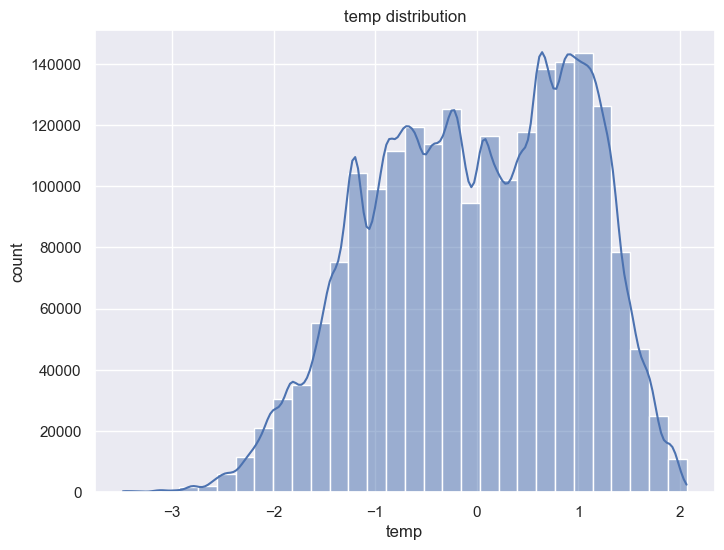

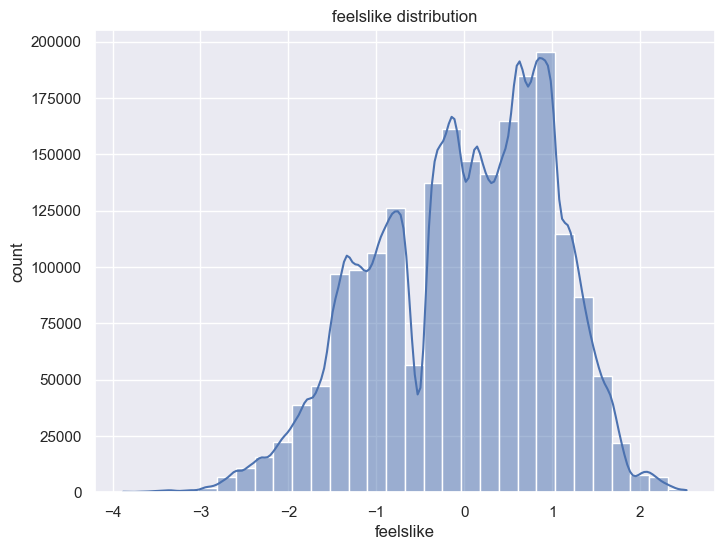

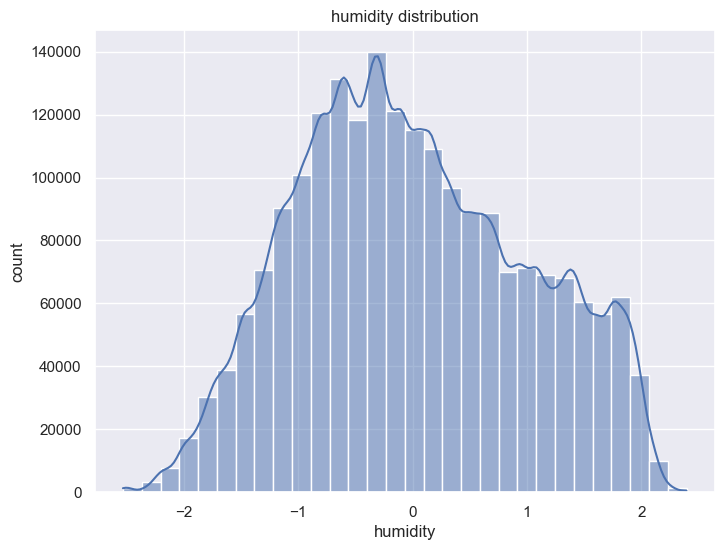

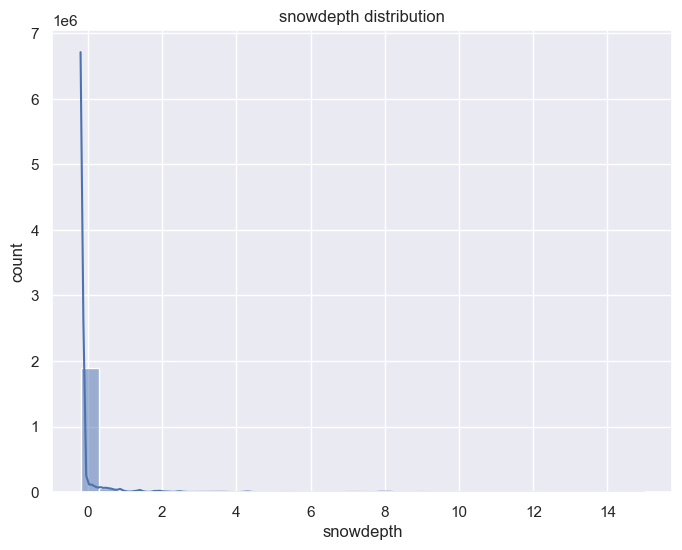

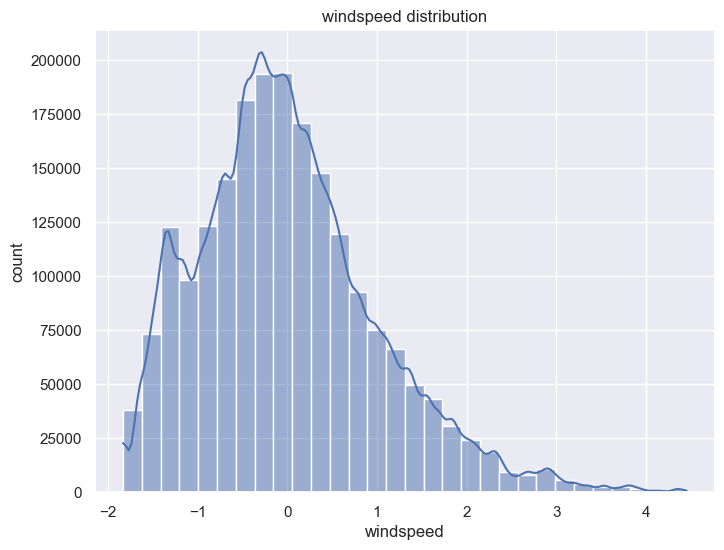

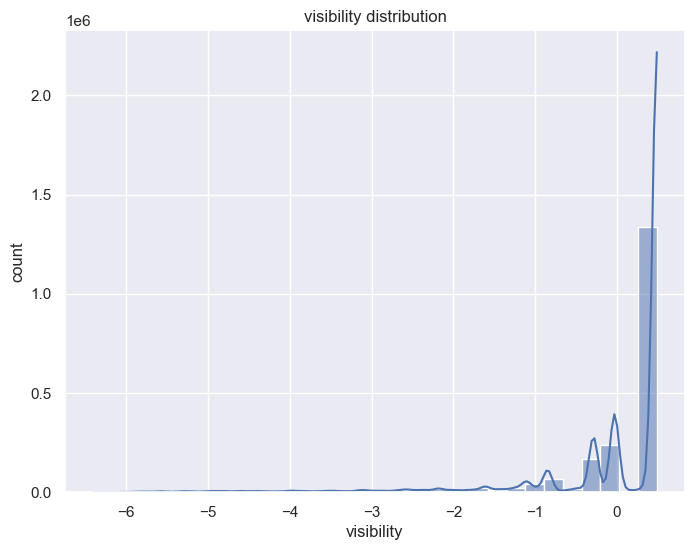

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# 数值特征列表
numerical_features = ['temp', 'feelslike', 'humidity', 'snowdepth', 'windspeed', 'visibility']

# 绘制数值特征的分布图
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(X_train[feature], bins=30, kde=True)
    plt.title(f'{feature} distribution')
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()




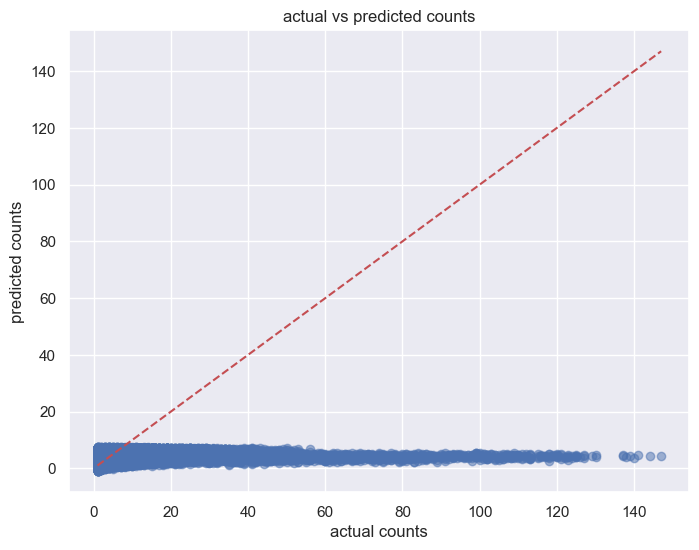

In [48]:
# 假设你已经有 y_test 和 y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 45度参考线
plt.xlabel('actual counts')
plt.ylabel('predicted counts')
plt.title('actual vs predicted counts')
plt.show()


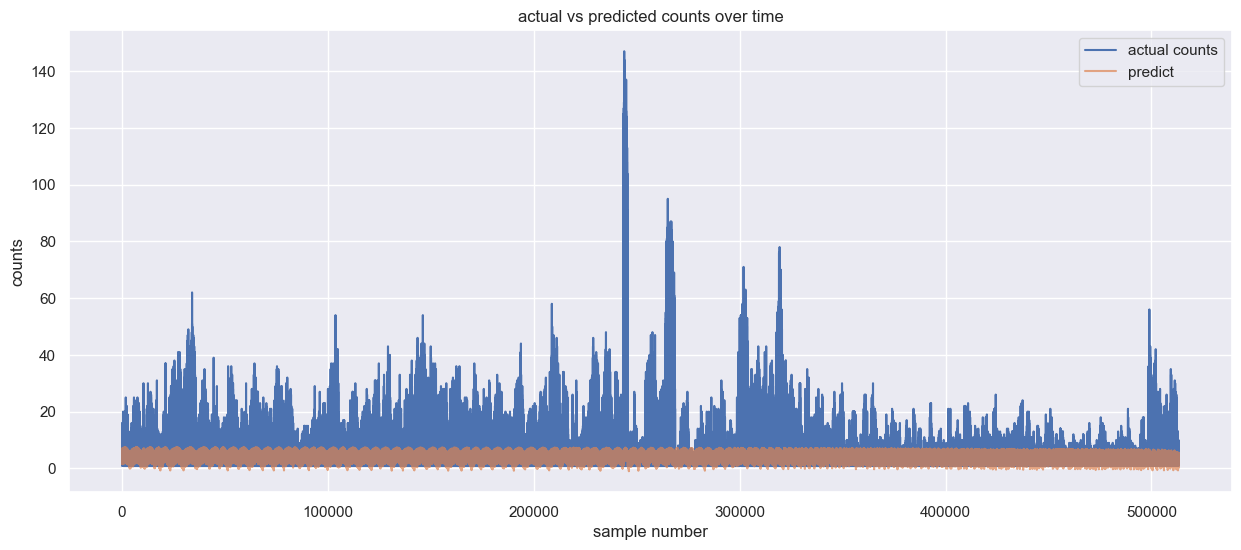

In [49]:
# 假设 y_test 的索引是时间戳
plt.figure(figsize=(15, 6))
plt.plot(y_test.reset_index(drop=True), label='actual counts')
plt.plot(y_pred, label='predict', alpha=0.7)
plt.xlabel('sample number')
plt.ylabel('counts')
plt.title('actual vs predicted counts over time')
plt.legend()
plt.show()
